In [23]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV,DSP,Optim
PythonPlot.svg(true)
include("model.jl")
include("formulas.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

# Load data

In [24]:
# make dataframe from CSV file
include("./process_mm_data.jl")
DATA_PATH = "./data/MC4100_25C"
data = [CSV.read(DATA_PATH*"/"*f,DataFrame,header=string.(["row","div","length","x","z"])) for f in readdir(DATA_PATH)]
data = vcat([hcat(data[i],DataFrame(:lineage=>i*ones(length(data[i][:,1])))) for i in eachindex(data)]...)
data = combine(groupby(data,:lineage),:div => cumsum => :n,names(data));


# Apply the function to each lineage and concatenate results
data = vcat([process_lineage(c) for c in groupby(data, :lineage)]...);
data.z = data.Y .- data.T .* log(2);
#data = data[data.lineage .==3,:]
dfcell = combine(groupby(data,[:lineage,:cell]),:z => (x -> x[1])=>:z0, 
    :Y => (x -> x[end] - x[1])=>:ϕ,
    :time => (x -> x[end]-x[1])=>:τ);
dfcell.λ = dfcell.ϕ ./ dfcell.τ ;
data.time = data.time .* mean(dfcell.λ)
data. τ = data.time .* mean(dfcell.λ)
dfcell.λ = dfcell.λ ./ mean(dfcell.λ)
dfcell.τ = dfcell.τ .* mean(dfcell.λ);
dfcell.λ = (dfcell.λ  .- mean(dfcell.λ)) ./ std(dfcell.λ);
dfcell.τ = (dfcell.τ  .- mean(dfcell.τ)) ./ std(dfcell.τ);

# Plot data

In [25]:
α = mean([-cov(d.ϕ,d.z0)/var(d.z0) for d in groupby(dfcell,:lineage)])
ρ =  mean([cor(d.λ[2:end],d.λ[1:end-1]) for d in groupby(dfcell,:lineage)])
α_std = std([-cov(d.ϕ,d.z0)/var(d.z0) for d in groupby(dfcell,:lineage)])
ρ_std =  std([cor(d.λ[2:end],d.λ[1:end-1]) for d in groupby(dfcell,:lineage)])

0.15734829464841082

In [26]:
ρ =  mean([cor(d.λ[2:end],d.λ[1:end-1]) for d in groupby(dfcell,:lineage)])


0.1345528804573762

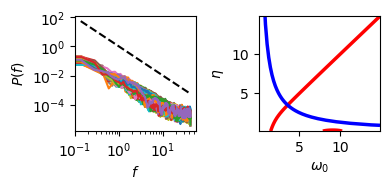

In [27]:

ηrange_ = collect(0.1:0.2:15.0)
ω0range_ = collect(0.1:0.2:15.0)

# Preallocate
alpha_vals = zeros(length(ω0range_), length(ηrange_))
rho_vals = zeros(length(ω0range_), length(ηrange_))


# Populate the matrix
for (i, ω0) in enumerate(ω0range_)
    for (j, η) in enumerate(ηrange_)
        alpha_vals[i, j] = alpha_SHO(η * ω0, ω0, 1 / log(2), η)
        rho_vals[i, j] = rho_SHO(η, ω0, 1 / log(2), 1)
    end
end

# Transpose for correct orientation in PyPlot
alpha_vals = alpha_vals'
rho_vals = rho_vals'



# Plot
fig, axs = subplots(figsize=(4, 2),ncols=2)
ax = axs[0]
freqs_sims = []
lineages = data.lineage |> unique
for lin in lineages
    df = data[data.lineage .== lin,:]
    z =df.z
    dt = df.time[end] - df.time[end-1]
    fs = 1 / dt  # sampling frequency in Hz

    # Compute PSD using Welch’s method
    p = welch_pgram(z, fs=fs)
    freqs_sims = Vector(p.freq)
    psd_sims = p.power


    ax.loglog(freqs_sims, psd_sims,"-")
end
ax.loglog(freqs_sims, 1 ./ freqs_sims .^2,"k--")
ax.set_xlabel(L"f")
ax.set_ylabel(L"P(f)")



ax = axs[1]

# cs = ax.contour(ω0range_,ηrange_,alpha_vals,levels=5,cmap="Reds",alpha=0.8)
# cs = ax.contour(ω0range_,ηrange_,rho_vals,levels=5,cmap="Blues",alpha=0.8)
cs = ax.contour(ω0range_,ηrange_,alpha_vals,levels=[0.5], colors="r", linewidths=2.5)
cs = ax.contour(ω0range_,ηrange_,rho_vals,levels=[0.1], colors="b", linewidths=2.5)
#ax.clabel(cs,cs.levels, inline=true, fontsize=8)
#ax.s()

# Label contours


# Labels and title
ax.set_xlabel(L"\omega_0")
ax.set_ylabel(L"\eta")
tight_layout()
savefig(joinpath(FIG_PATH, "fig5_contour.pdf"), bbox_inches="tight", pad_inches=0, format="pdf")

fig

# Heat map -- independently driven rates model

In [8]:
# --------------------------------------------------
data_sho= CSV.read("./output/sho_data_cells_2d.csv",DataFrame);
ω0range_sho = data_sho.ω0 |> unique |> sort;
ηrange_sho = data_sho.η |> unique |> sort;
qrange_sho = data_sho.q |> unique |> sort;

# --------------------------------------------------
data_ratio= CSV.read("./output/ratio_data_cells.csv",DataFrame);
data_ratio = data_ratio[data_ratio.cell .< 100,:]
arange_ratio = data_ratio.a |> unique |> sort;
brange_ratio = data_ratio.b |> unique |> sort;

In [9]:
agged_covariances(d, 5) for d groupby(data_ratio, [:a, :b]) do subdf
    # Perform operations on each subgroup
    l
end

UndefVarError: UndefVarError: `agged_covariances` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [10]:
lgs = 10
W_data = [coarse_grained1D(dfcell[dfcell.lineage .== i,:],lgs) for i in unique(dfcell.lineage)]

dataq0 = data[data.q .== 0,:]

Wy1 = zeros(length(ηrange), length(ω0range))
Wy2 = zeros(length(ηrange), length(ω0range))
Wϕ1 = zeros(length(ηrange), length(ω0range))
err = zeros(length(ηrange), length(ω0range))
ρ = zeros(length(ηrange), length(ω0range))
for i in 1:length(ηrange)
    for j in 1:length(ω0range)
        dataq0ηω0 = dataq0[(dataq0.η .== ηrange[i]) .&& (dataq0.ω0 .== ω0range[j]),:]
        W = coarse_grained1D(dataq0ηω0,lgs)
        Wy1[i,j] = W[2][1]
        Wy2[i,j] = W[2][2]
        Wϕ1[i,j] = W[1][1]
        err[i,j] = [(W[2][1] - wd[2][1])^2 + (W[2][2] - wd[2][2])^2 + (W[1][1] - wd[1][1])^2 for wd in W_data] |> mean |> sqrt
        vdata = mean(hcat([[wd[2][1], wd[2][2], wd[1][1]] for wd in W_data]...),dims=2)[:,1]
        vsim = [W[2][1],W[2][2],W[1][1]]
        ρ[i,j] = cor(vdata,vsim)
    end
end
err = err[2:end,2:end]
Wy1 = Wy1[2:end,2:end]
Wy2 = Wy2[2:end,2:end]
Wϕ1 = Wϕ1[2:end,2:end]
ρ

ArgumentError: ArgumentError: column name "q" not found in the data frame; existing most similar names are: "S", "T", "Y", "n", "x", "z", "τ" and "z0"

In [11]:
fig,ax = subplots(figsize=(2, 2))
ax.plot(Wy1[1,:])
ax.set_ylim([-3,1])
fig

UndefVarError: UndefVarError: `Wy1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [12]:
# make a heatmap of Wy1
fig, axs = subplots(figsize=(3, 3),nrows=2,sharey=true,sharex=true)

ax = axs[0]
c = ax.imshow(ρ, aspect="auto", origin="lower",
              extent=(ω0range[1], ω0range[end], ηrange[1], ηrange[end]))
ax.set_ylabel(L"\eta")
ax.set_title(L"$\rho_{\rm data,\rm simulation}$")
cbar = fig.colorbar(c, ax=ax)

ax = axs[1]
c = ax.imshow(err, aspect="auto", origin="lower",
              extent=(ω0range[1], ω0range[end], ηrange[1], ηrange[end]))
ax.set_xlabel(L"\omega_0")
ax.set_ylabel(L"\eta")
ax.set_title(L"${\rm MSE}_{\rm data,\rm simulation}$")
cbar = fig.colorbar(c, ax=ax)
tight_layout()
savefig(joinpath(FIG_PATH, "fig5_heatmaps.pdf"), bbox_inches="tight")
fig

UndefVarError: UndefVarError: `ω0range` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Examples

In [13]:
include("model.jl")
vz = 0.001
function make_data_model1(η,ω0,T)
    a = ω0*η
    dt = 0.01
    σ = sqrt(vz*a*ω0^2) # variance of noise in z
    params = build_model2d(a,a,ω0,0.0,σ,0.0)
    init = [0.0, 0.0, 0.0, 0.0]
    df = make_sim_df(init, params, dt, T)
    df.ω0 .= ω0;
    df.η .= η;
    df.y = df.z .+ df.θ .* log(2)

    dfcell_sim = combine(groupby(df, :cell),
                    :z => first => :z0,
                    :y => (x -> x[end] - x[1]) => :ϕ,
                    :time => (x -> x[end] - x[1]) => :τ,
                    :x1 => mean => :x1,
                    :x2 => mean => :x2)
    dfcell_sim.λ = dfcell_sim.ϕ ./dfcell_sim.τ
    dfcell_sim.q .= 0




  
    df.q .= 0

    dfcell_sim.ω0 .= ω0
    dfcell_sim.η .= η
    dfcell_sim.isphys .=  isphysical(df)

    return df,dfcell_sim
end

function make_data_model2(a,b,T)
    dt = 0.01
    ϕ0 = log(2)
    σ1 = sqrt(vz*a) # variance of noise in z
    σ2 = 0.005
    α = 0.5
    init = [0.0,0.0,0.0,0.0]
    params = (a,b,ϕ0,α,σ1,σ2)
    df = make_sim_df_ratio_model(init, params, dt, T);
    df.y = df.z .+ log(2) .*df.θ;

    dfcell_sim = combine(groupby(df, :cell),
        :z => first => :z0,
        :y => (x -> x[end] - x[1]) => :ϕ,
        :time => (x -> x[end] - x[1]) => :τ,
        :x1 => mean => :x1,
        :x2 => mean => :x2,
    )
    dfcell_sim.λ .= dfcell_sim.ϕ ./ dfcell_sim.τ
    dfcell_sim.a .= a
    dfcell_sim.b .= b

    return df,dfcell_sim
end

make_data_model2 (generic function with 1 method)

In [19]:
α = mean([-cov(d.ϕ,d.z0)/var(d.z0) for d in groupby(dfcell,:lineage)])
ρ =  mean([cor(d.λ[2:end],d.λ[1:end-1]) for d in groupby(dfcell,:lineage)])
α_std = std([-cov(d.ϕ,d.z0)/var(d.z0) for d in groupby(dfcell,:lineage)])
ρ_std =  std([cor(d.λ[2:end],d.λ[1:end-1]) for d in groupby(dfcell,:lineage)])
# print results
println(α)
println(ρ)

0.5019712723503965
0.1345528804573762


In [20]:
ρ_std

0.15734829464841082

In [21]:
df_sim,dfcell_sim = make_data_model2(2,0.0,200)
α = -cov(dfcell_sim.ϕ,dfcell_sim.z0)/var(dfcell_sim.z0) 
ρ =  cor(dfcell_sim.λ[2:end],dfcell_sim.λ[1:end-1])
println(α)
println(ρ)
var(dfcell_sim.ϕ[1:40])

0.7228337705958671
0.4484471174910756


5.114729722610147e-5

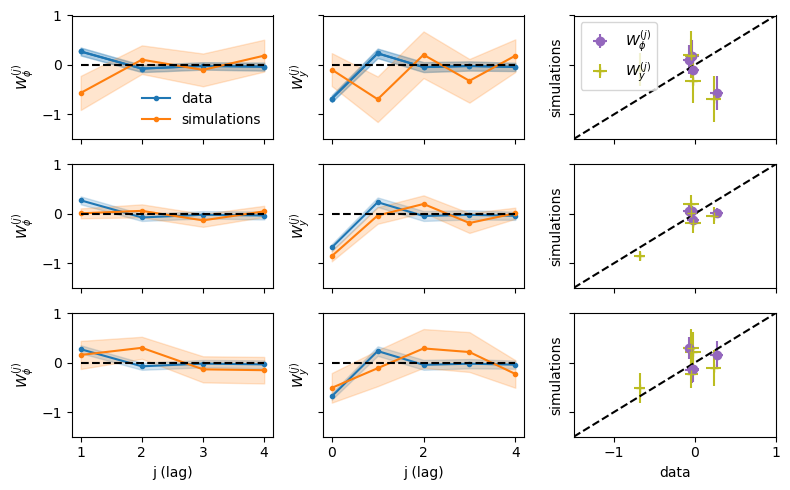

In [36]:
lgs = 4

W_data = [coarse_grained1D(dfcell[dfcell.lineage .== i,:],lgs) for i in unique(dfcell.lineage)]
W_data = W_data
W_sims1 = [coarse_grained1D(make_data_model1(3,4.5,100)[2],lgs) for i in 1:60];
W_sims2 = [coarse_grained1D(make_data_model1(6,15,100)[2],lgs) for i in 1:60];
W_sims3 = [coarse_grained1D(make_data_model2(1,0.0,100)[2],lgs) for i in 1:60];

# -- Helper function to compute and plot mean with 95% CI --
function plot_mean_and_ci(ax, data::Vector{Vector{Float64}}, color::String; label="", xoffset=0)
    X = hcat(data...)
    m = mean(X, dims=2)[:, 1]
    v = 1.96 * std(X, dims=2)[:, 1] / sqrt(size(X, 2))
    x = xoffset:(length(m) - 1 + xoffset)
    ax.plot(x, m, color * ".-", label=label)
    ax.fill_between(x, m .- v, m .+ v, alpha=0.2, color=color)
    return m, v
end

# -- Setup figure and axes --
fig, axs = subplots(figsize=(8, 5), ncols=3, nrows=3, sharey="row", sharex="col")

# -- Precompute data means and error bars --
W1_data = [W[1] for W in W_data]
W2_data = [W[2] for W in W_data]
m1_data, v1_data = plot_mean_and_ci(axs[0, 0], W1_data, "C0", label="data", xoffset=1)
m2_data, v2_data = plot_mean_and_ci(axs[0, 1], W2_data, "C0", xoffset=0)

# Store precomputed for reuse
mean_std = Dict(
    :W1_data => (m1_data, v1_data),
    :W2_data => (m2_data, v2_data)
)

# -- Simulation sets --
sim_sets = [W_sims1, W_sims2, W_sims3]

for (i, W_sim) in enumerate(sim_sets)
    # Left column: W_phi^j
    ax = axs[i-1, 0]
    plot_mean_and_ci(ax, W1_data, "C0", xoffset=1)
    m1_sim, v1_sim = plot_mean_and_ci(ax, [W[1] for W in W_sim], "C1", label="simulations", xoffset=1)
    ax.plot([1, length(m1_data)], [0, 0], "k--")
    if i == 1
        ax.legend(frameon=false)
    end
    ax.set_ylabel("\$W_{\\phi}^{(j)}\$")

    # Middle column: W_y^j
    ax = axs[i-1, 1]
    plot_mean_and_ci(ax, W2_data, "C0", xoffset=0)
    m2_sim, v2_sim = plot_mean_and_ci(ax, [W[2] for W in W_sim], "C1", xoffset=0)
    ax.plot([0, length(m2_data) - 1], [0, 0], "k--")
    ax.set_ylabel("\$W_{y}^{(j)}\$")

    # Bottom row: add x labels
    if i == 3
        axs[i-1, 0].set_xlabel("j (lag)")
        axs[i-1, 1].set_xlabel("j (lag)")
        axs[i-1, 2].set_xlabel("data")
    end

    # Right column: data vs sim scatter with error bars (W_phi)
    ax = axs[i-1, 2]
    ax.set_ylabel("simulations")
    ax.errorbar(m1_data, m1_sim, xerr=v1_data, yerr=v1_sim,
                fmt="o", color="C4",capsize=0,label="\$W_{\\phi}^{(j)}\$")
    lims = extrema(vcat(m1_data, m1_sim))
    ax.errorbar(m2_data, m2_sim, xerr=v2_data, yerr=v2_sim,
                fmt="+", color="C8",capsize=0,label="\$W_{y}^{(j)}\$")
    lims = extrema(vcat(m2_data, m2_sim))
    ax.plot([-1.5,1], [-1.5,1], "k--")
    ax.set_xlim(-1.5,1)
    ax.set_ylim(-1.5,1)
end
axs[0,2].legend()

tight_layout()
savefig(joinpath(FIG_PATH, "fig5_Wgrid.pdf"), bbox_inches="tight")
fig

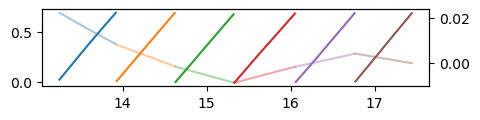

In [303]:

fig,ax = subplots(figsize=(5,1))
axt = ax.twinx()
for cell in unique(dfcell_sim.cell)[20:25]
    d = df_sim[df_sim.cell .== cell,:]
    ax.plot(d.time,d.y)
    axt.plot(d.time,d.z,alpha=0.4)
end
fig

# Coarse-grained dynamics

In [256]:
z = data.z
dt = data.time[end] - data.time[end-1]
fs = 1 / dt  # sampling frequency in Hz

# Compute PSD using Welch’s method
p = welch_pgram(z, fs=fs)
freqs_sims = Vector(p.freq)
psd_sims = p.power

fig, ax= subplots(figsize=(3,3))



ax.loglog(freqs_sims, psd_sims,"-")
ax.loglog(freqs_sims, 1 ./ freqs_sims .^2,"k--")
fig

ArgumentError: ArgumentError: column name "z" not found in the data frame; existing most similar names are: "c", "q", "z0", "η", "λ", "τ" and "ϕ"

# Coarse-graining code

In [32]:
d = dfcell
α_data = -cov(d.ϕ, d.z0) / var(d.z0)
αλ_data = -cov(d.ϕ ./ d.τ, d.z0) / var(d.z0)

0.0013771778590476599

In [32]:
α_data

0.44367690435887525

In [33]:
function coarse_grained(dfcell::DataFrame, l::Int)
    n = nrow(dfcell)

    Y = vcat(dfcell.ϕ[l+1:end],dfcell.z0[l+1:end])
    X = zeros(n-l, 3l+1)

    for j in 1:l # each j represents a lag and we are filling in ALL rows for that lag
        X[:, j] = dfcell.ϕ[l-j+1:end-j]
        X[:, l+j+1] = dfcell.λ[l-j+1:end-j]
        X[:, l + j+1] = dfcell.z0[l-j+1:end-j]
    end
    X[:, l+1] = dfcell.z0[l+1:end];
     # Add intercept column
    X_aug = hcat(ones(size(X, 1)), X)
    
    # Solve normal equations via least squares
    β = X_aug \ Y  # (X'X)β = X'Y
    βϕ = β[2:l+1]
    βz = β[l+2:end]
    return βϕ,βz, X_aug, Y

end

coarse_grained (generic function with 1 method)